In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import yaml
import scipy


speeds = [20,25,30,35,40]
controllers=['stanley', 'purePursuit', 'mpc', 'modifiedStanley']
map_name = 'map3'

plt.rcParams.update({
		# Base font and size settings
		'font.size': 10,           # Base font size
		'font.family': 'serif',
		'font.serif': ['Caladea', 'TeX Gyre Termes', 'Times New Roman', 'DejaVu Serif'],
		'font.sans-serif': ['Carlito', 'TeX Gyre Heros', 'DejaVu Sans'],
		'font.monospace': ['Computer Modern Typewriter', 'DejaVu Sans Mono'],
		
		# Text rendering
		'text.usetex': False,      # Set to True if you have LaTeX installed
		'text.latex.preamble': r'\usepackage{amsmath,amssymb,amsfonts}',
		
		# Element sizes
		'axes.titlesize': 10,      # Title font size
		'axes.labelsize': 10,      # Axis label font size
		'xtick.labelsize': 9,      # X-axis tick label size
		'ytick.labelsize': 9,      # Y-axis tick label size
		'legend.fontsize': 8,      # Legend font size
		'figure.titlesize': 11,    # Figure title size
		
		# Figure properties
		'figure.autolayout': True, # Automatically adjust subplot params
		'figure.dpi': 300,
		
		# Save settings
		'savefig.dpi': 300,        # High DPI for PDF exports
		'savefig.format': 'pdf',   # Default save format
		'savefig.bbox': 'tight',   # Tight bounding box
		'savefig.pad_inches': 0.1, # Small padding
		'savefig.transparent': True, # Transparent background
		
		# Grid and axes styling
		'axes.grid': True,
		'grid.alpha': 0.3,
		'axes.linewidth': 0.8,
		'xtick.major.width': 0.8,
		'ytick.major.width': 0.8,
		
		# Legend styling
		'legend.frameon': True,
		'legend.framealpha': 0.9,
		'legend.edgecolor': 'black',
		'legend.fancybox': False
	})

print("Matplotlib configured for LaTeX-style formatting")
print("Text rendering:", plt.rcParams['text.usetex'])
print("Font family:", plt.rcParams['font.family'])
print(f"Extracting centre line for: {map_name}")

Matplotlib configured for LaTeX-style formatting
Text rendering: False
Font family: ['serif']
Extracting centre line for: map3


In [2]:
def load_parameter_file(yaml_file):
	with open(yaml_file, 'r') as file:
		map_metadata = yaml.safe_load(file)
		map_resolution = map_metadata['resolution']
		origin = map_metadata['origin']
	return map_resolution, origin

def nearest_point(point, trajectory):
	"""
	Return the nearest point along the given piecewise linear trajectory.

	Args:
		point (numpy.ndarray, (2, )): (x, y) of current pose
		trajectory (numpy.ndarray, (N, 2)): array of (x, y) trajectory waypoints
			NOTE: points in trajectory must be unique. If they are not unique, a divide by 0 error will destroy the world

	Returns:
		nearest_point (numpy.ndarray, (2, )): nearest point on the trajectory to the point
		nearest_dist (float): distance to the nearest point
		t (float): nearest point's location as a segment between 0 and 1 on the vector formed by the closest two points on the trajectory. (p_i---*-------p_i+1)
		i (int): index of nearest point in the array of trajectory waypoints
	"""

	trajectory = trajectory[:, :2]
	diffs = trajectory[1:] - trajectory[:-1]
	l2s = np.sum(diffs**2, axis=1)
	dots = np.einsum('ij,ij->i', point - trajectory[:-1], diffs)
	t = np.clip(dots / l2s, 0.0, 1.0)
	projections = trajectory[:-1] + t[:, np.newaxis] * diffs
	dists = np.linalg.norm(point - projections, axis=1)
	min_dist_segment = np.argmin(dists)
	return projections[min_dist_segment], dists[min_dist_segment], t[min_dist_segment], min_dist_segment

def find_lap_indices(poses, raceline):
    start_point = poses[0, 0:2]
    _, _, _, start_index = nearest_point(start_point, raceline[:, :2])

    laps = np.zeros(poses.shape[0], dtype=int)
    l = 1
    prev_index = start_index

    for i in range(poses.shape[0]):
        point = poses[i, :2]
        _, _, _, index = nearest_point(point, raceline[:, :2])
        # print(index)
        # Detect crossing the start line (from high index to low index)
        if index < prev_index:  # Use a threshold to avoid noise
            l += 1
        laps[i] = l
        prev_index = index
    return laps



In [3]:
# Load map to get boundaries and raceline
import skimage


map_path = 'C:/Users/bbdnet2985/Desktop/Matsters/Report/Stellenbosch_University_Electrical_and_Electronic_Engineering_Template__1_/Results/maps'
map_yaml_path = f"{map_path}/{map_name}.yaml"
map_img = plt.imread(f'{map_path}/{map_name}.png')
map_img = np.flipud(map_img)
map_img = scipy.ndimage.distance_transform_edt(map_img)
map_img = np.abs(map_img - 1)
map_img[map_img!=0]=1
bx,by = np.where(map_img==0)


with open(map_yaml_path, 'r') as yaml_stream:
    try:
        map_metadata = yaml.safe_load(yaml_stream)
        map_resolution = map_metadata['resolution']
        origin = map_metadata['origin']
    except yaml.YAMLError as ex:
        print(ex)

bx = bx * map_resolution + origin[1]
by = by * map_resolution + origin[0]

raceline = np.loadtxt(f'{map_path}/{map_name}_minCurve.csv', delimiter=',')

def plot_map():
    plt.scatter(by, bx, c='black',marker='s',s=5)  # Plot the boundaries
    plt.plot(raceline[:,0], raceline[:,1], label='Raceline')  # Plot the raceline
    plt.axis('equal')
    plt.axis('off')

def plot_map(img=map_img):
		boundaries = skimage.measure.find_contours(img, 0.5)
		# print(f"Found {len(boundaries)} boundaries")
		# print(boundaries)
		# for boundary in boundaries:
		# 	plt.plot(boundary[:,1]*map_resolution + origin[0], boundary[:,0]*map_resolution + origin[1], 'black', linewidth=0.1)
		plt.plot(boundaries[0][:,1]*map_resolution + origin[0], boundaries[0][:,0]*map_resolution + origin[1], 'black', linewidth=0.5)
		plt.plot(boundaries[-1][:,1]*map_resolution + origin[0], boundaries[-1][:,0]*map_resolution + origin[1], 'black', linewidth=0.5)


# plt.figure()
# # plt.plot(raceline[:,0], raceline[:,1], c='red', linewidth=2)  # Plot the raceline
# plot_map()
# plt.show()

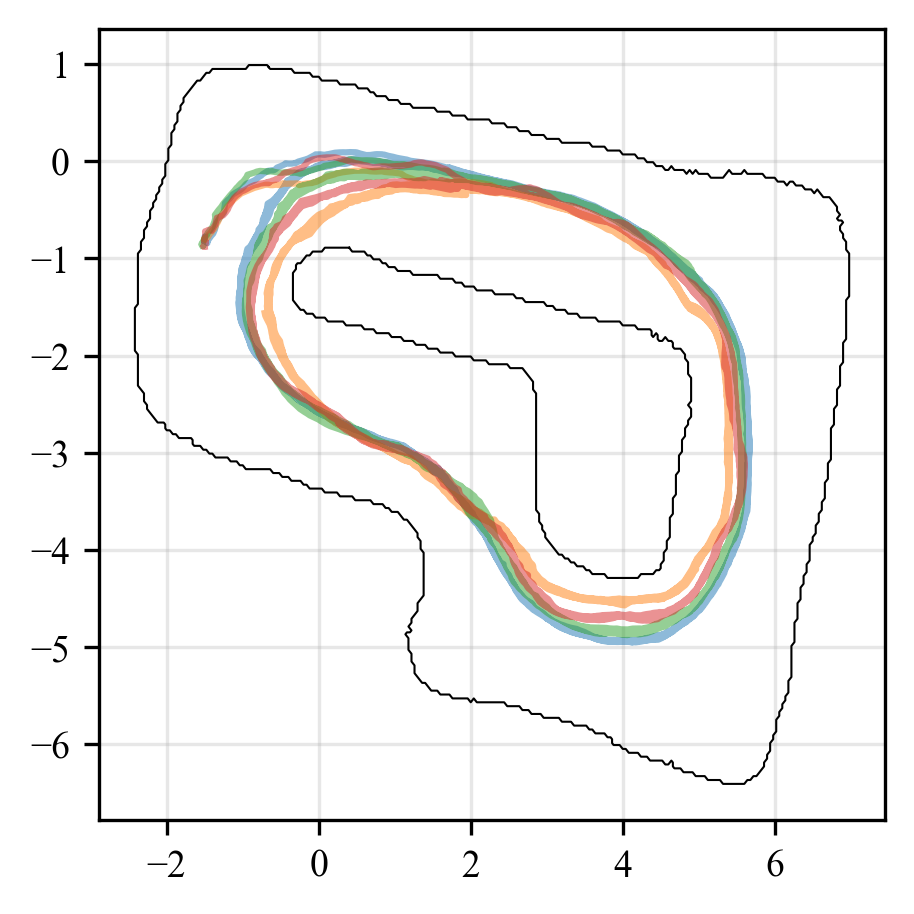

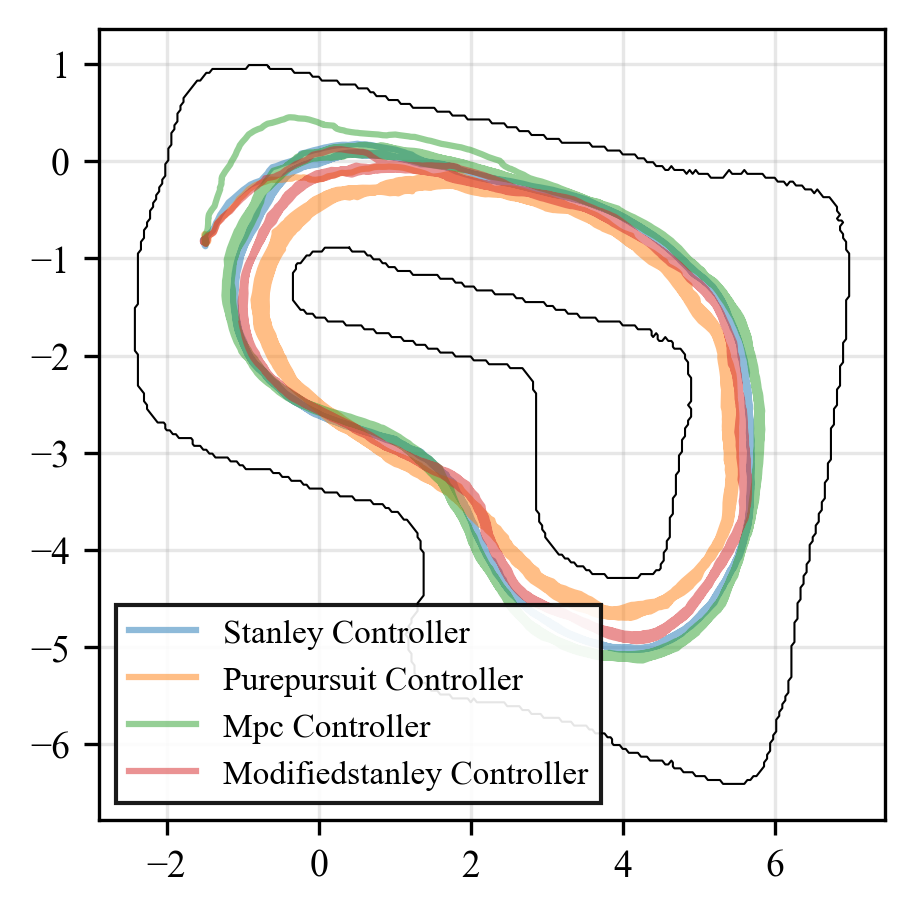

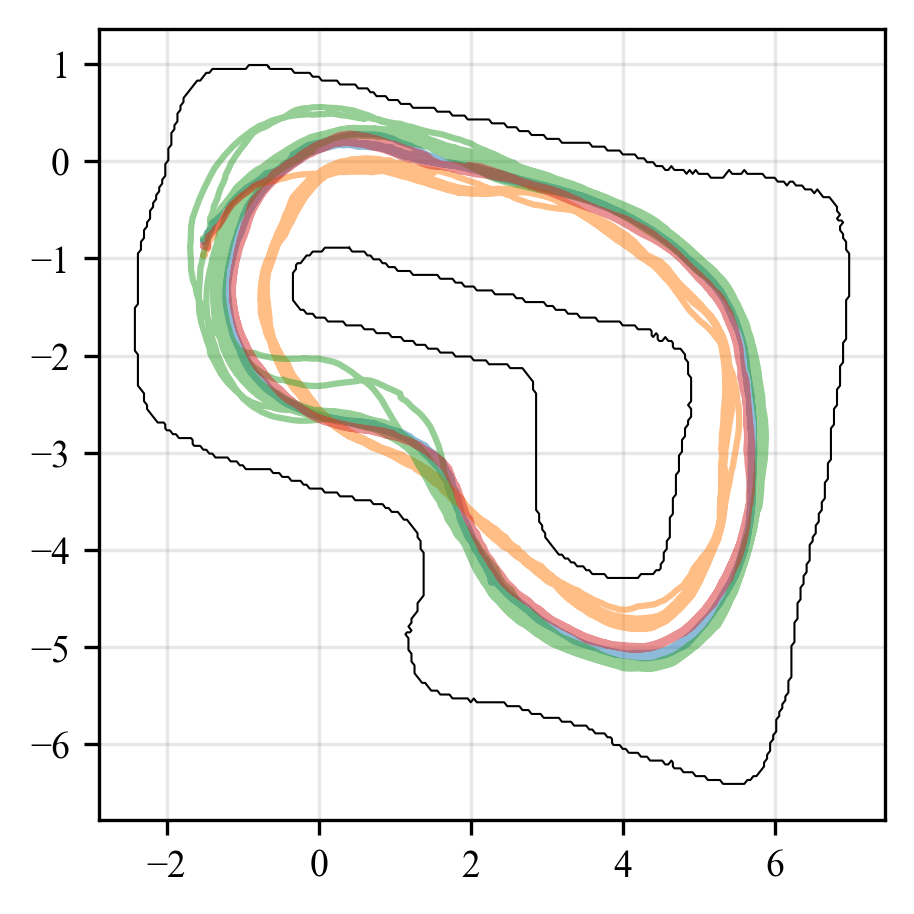

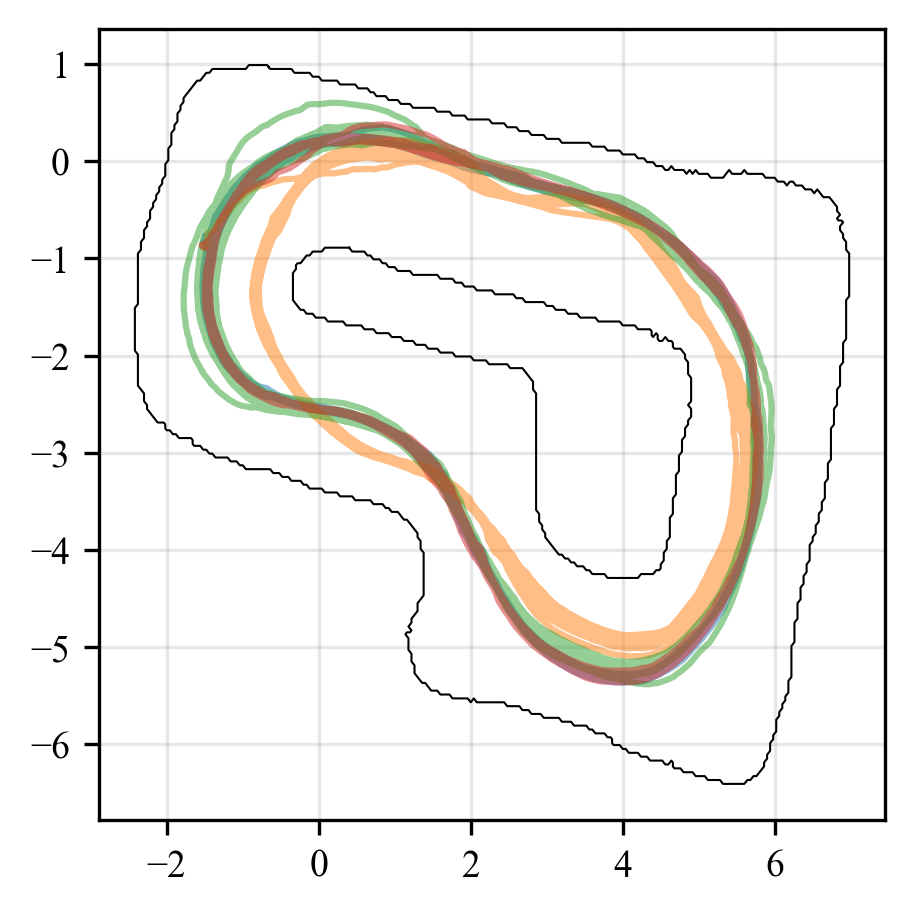

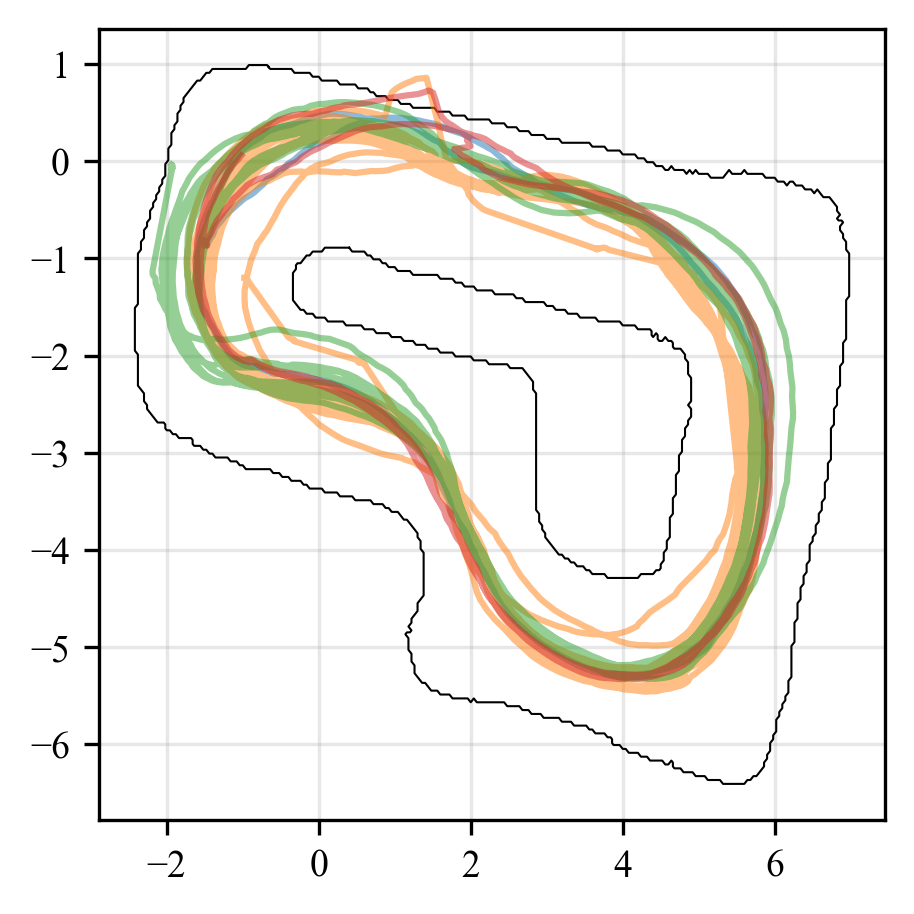

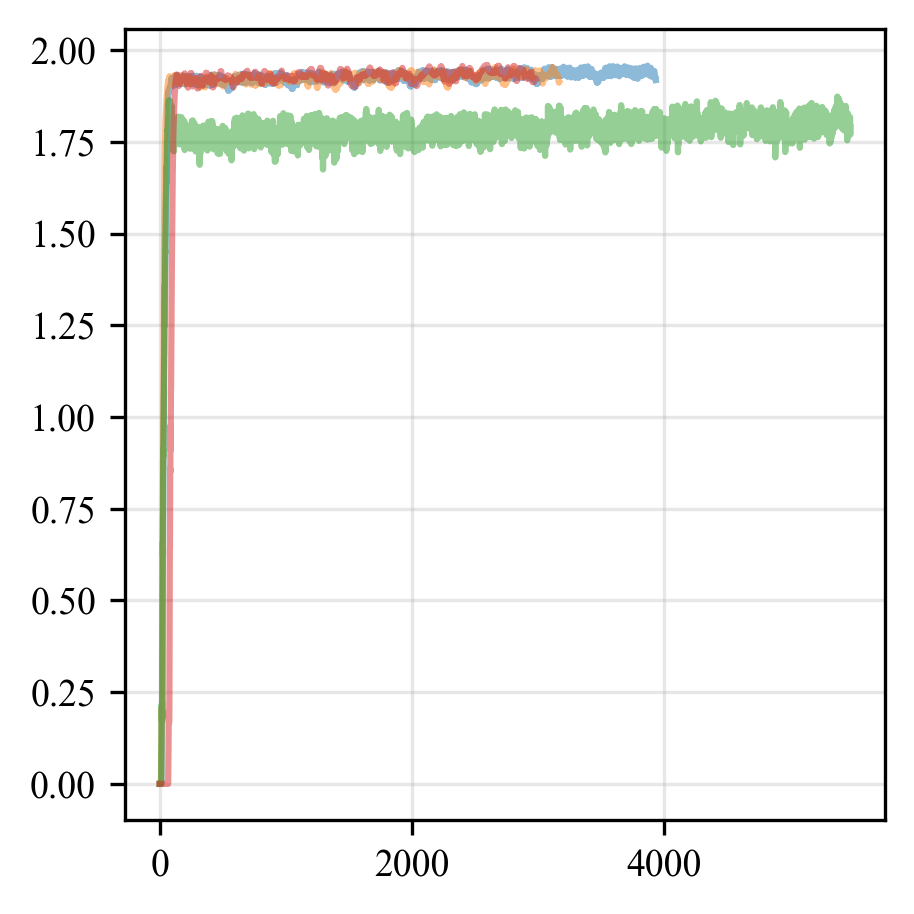

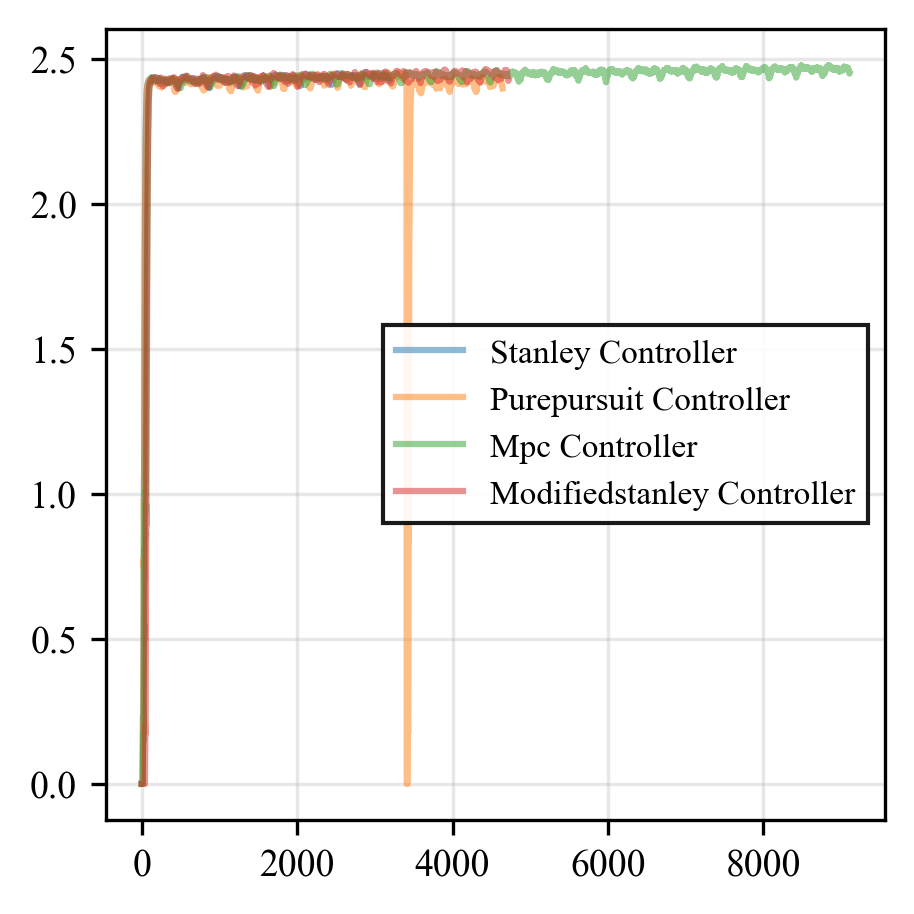

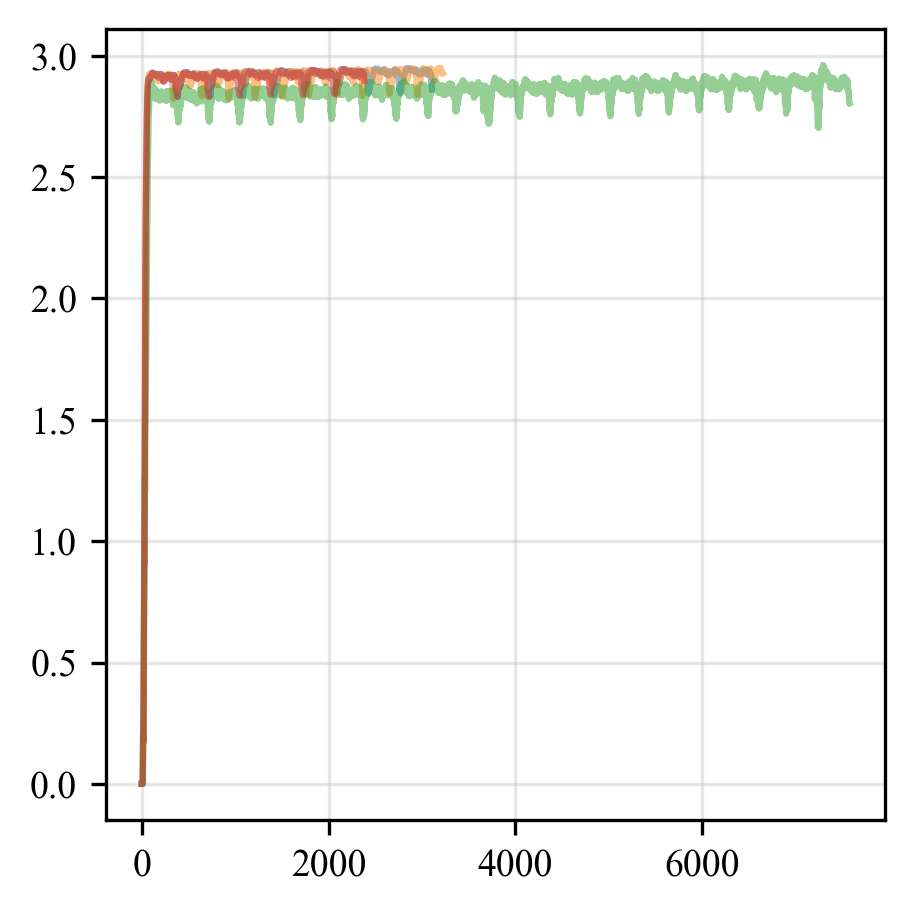

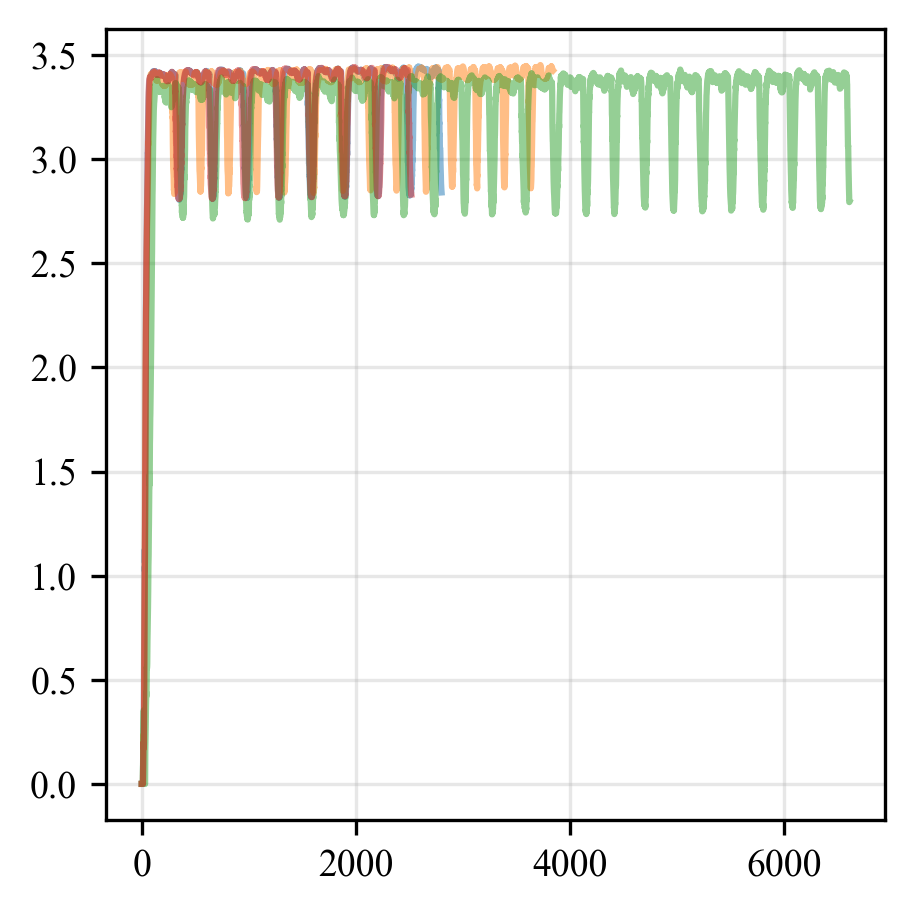

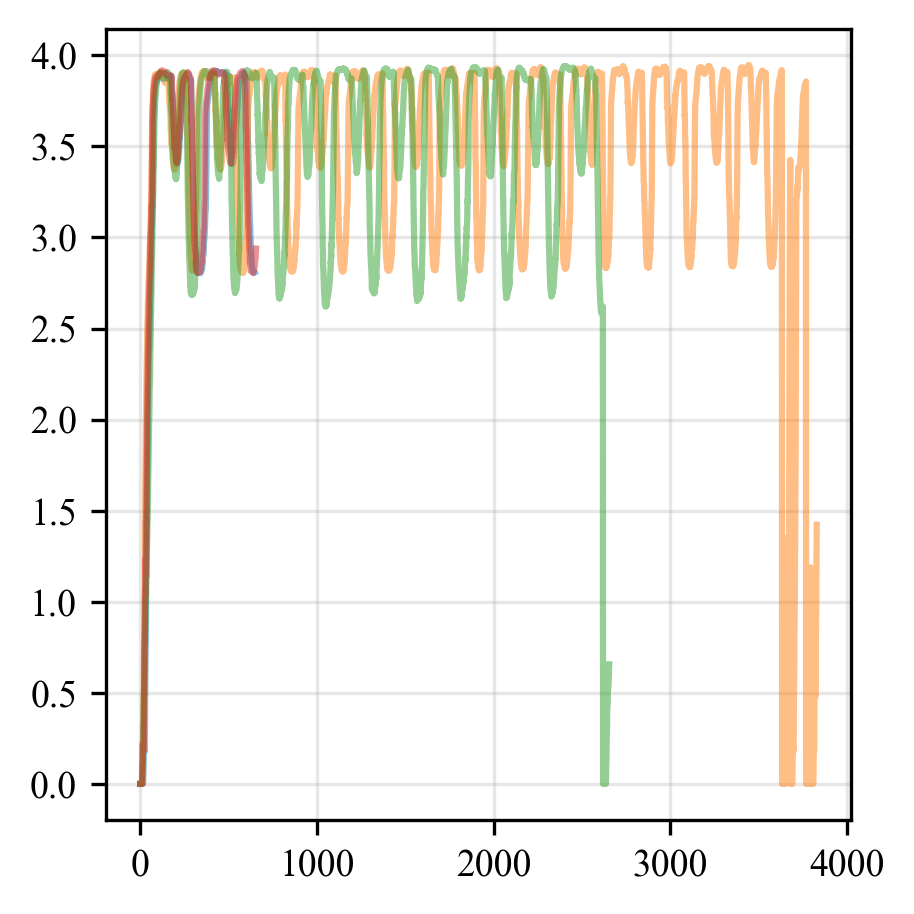

In [4]:
size = 8/2.54
for speed in speeds:
    plt.figure(figsize=(size, size))
    plot_map()
    for controller in controllers:
        run = np.loadtxt(f'C:\\Users\\bbdnet2985\\Desktop\\Matsters\\Report\\Stellenbosch_University_Electrical_and_Electronic_Engineering_Template__1_\\Results\\control\\real\\{controller}\\{speed}.csv',skiprows=1,delimiter=',')
        plt.plot(run[:,0], run[:,1], label=f'{controller.capitalize()} Controller', markersize=2, alpha=0.5)
    # plt.title(f'{speed} m/s')
    if speed == 25:
        plt.legend()
    plt.savefig(f'C:\\Users\\bbdnet2985\\Desktop\\Matsters\\Report\\Stellenbosch_University_Electrical_and_Electronic_Engineering_Template__1_\\Results\\control\\real\\{speed}.pdf', dpi=300, bbox_inches='tight', pad_inches=0.0, transparent=True, format='pdf')
    plt.show()

size = 8/2.54
for speed in speeds:
    plt.figure(figsize=(size, size))
    # plot_map()
    for controller in controllers:
        run = np.loadtxt(f'C:\\Users\\bbdnet2985\\Desktop\\Matsters\\Report\\Stellenbosch_University_Electrical_and_Electronic_Engineering_Template__1_\\Results\\control\\real\\{controller}\\{speed}.csv',skiprows=1,delimiter=',')
        plt.plot(run[:,3], label=f'{controller.capitalize()} Controller', markersize=2, alpha=0.5)
    # plt.title(f'{speed} m/s')
    if speed == 25:
        plt.legend()
    # plt.savefig(f'C:\\Users\\bbdnet2985\\Desktop\\Matsters\\Report\\Stellenbosch_University_Electrical_and_Electronic_Engineering_Template__1_\\Results\\control\\real\\{speed}.pdf', dpi=300, bbox_inches='tight', pad_inches=0.0, transparent=True, format='pdf')
    plt.show()
        

[ 1  2  3  4  5  6  7  8  9 10 11 12 13]


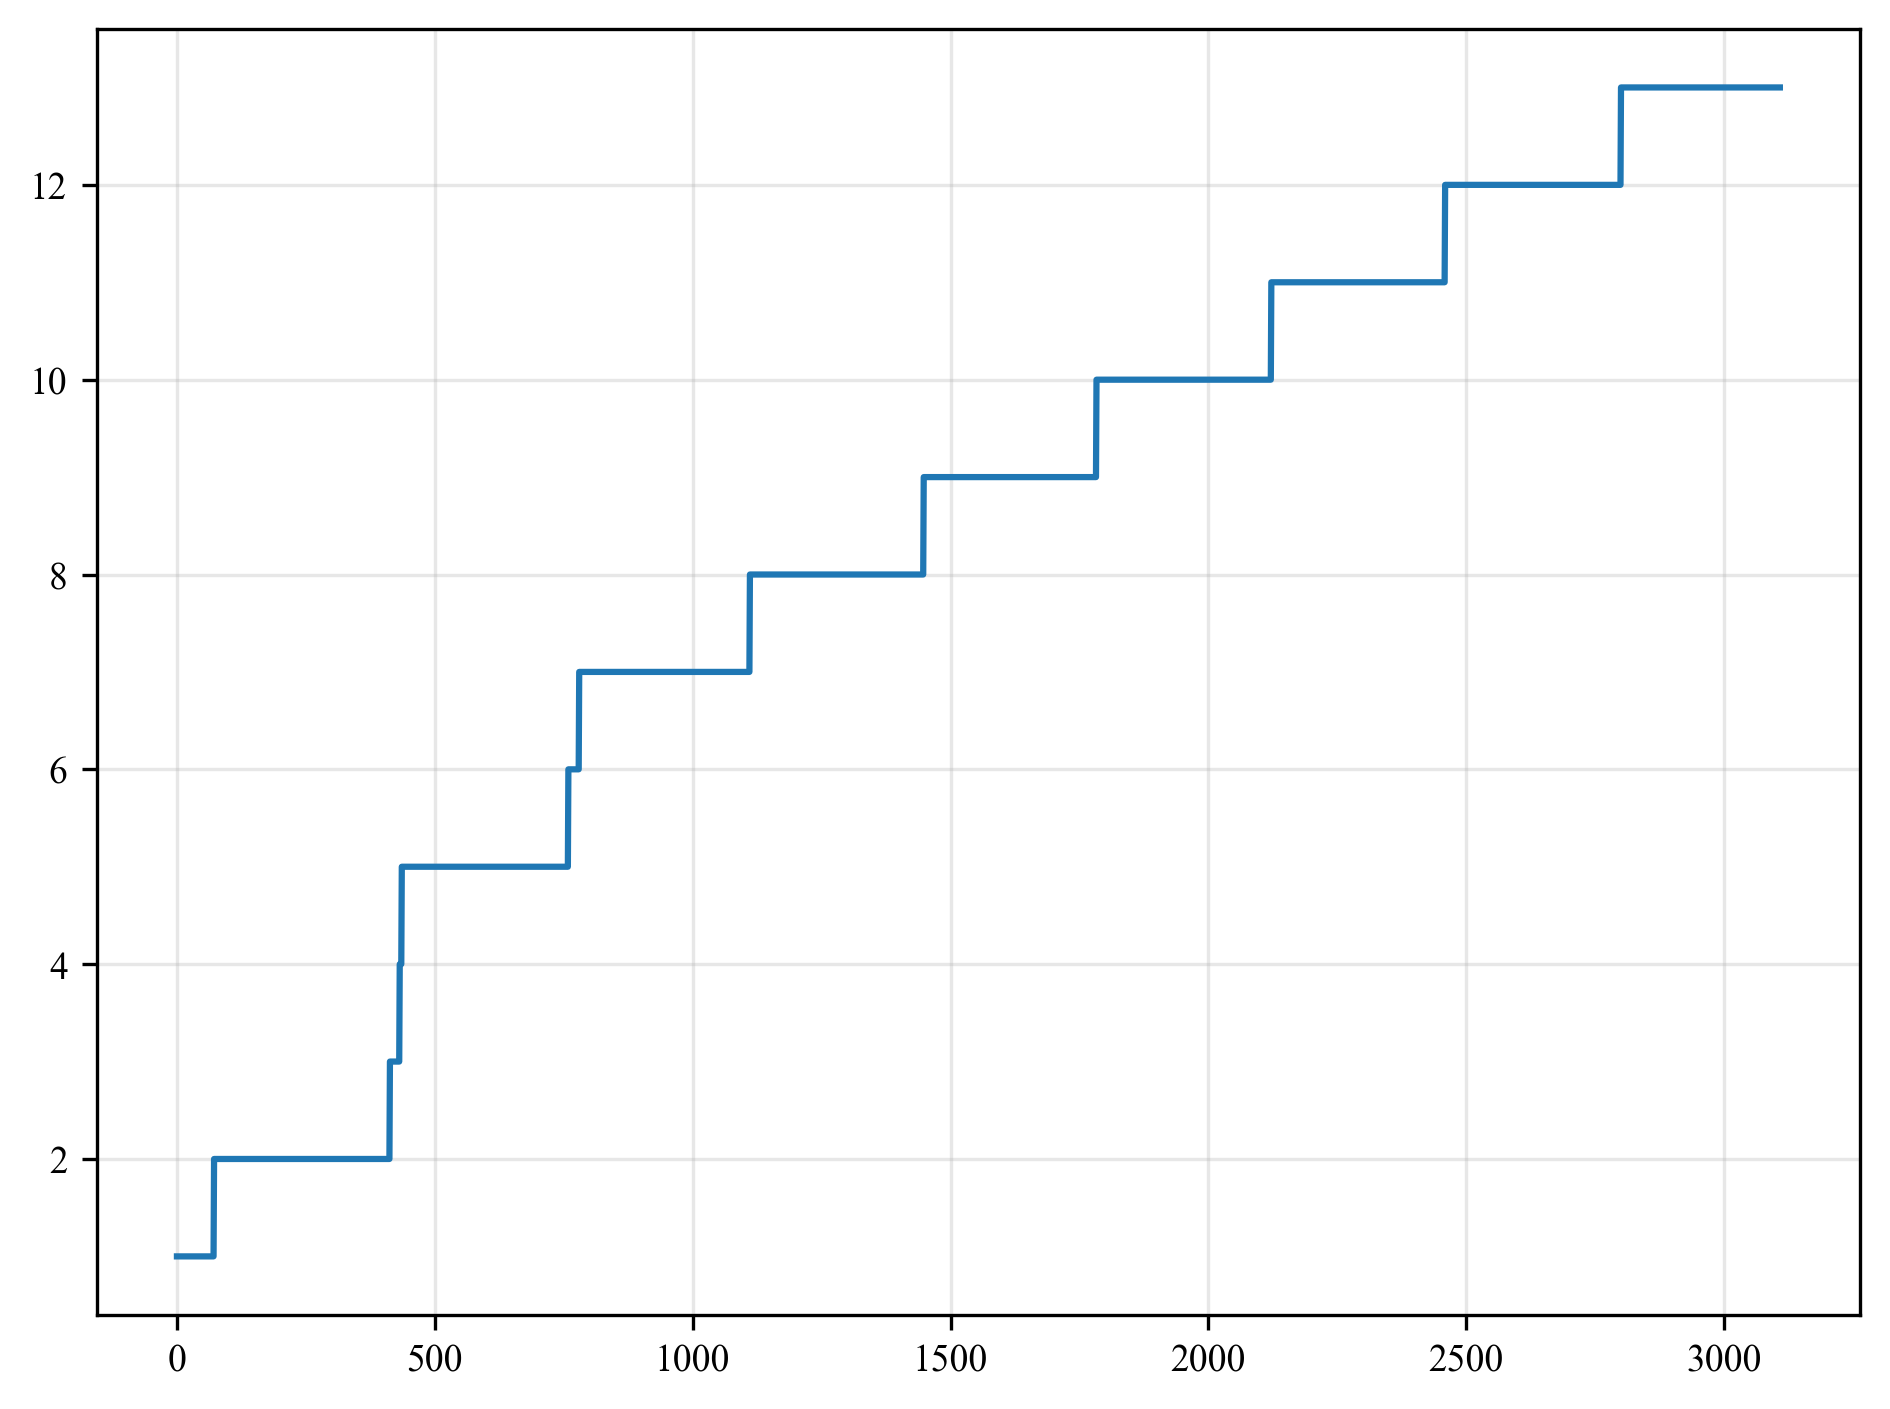

In [5]:
run = np.loadtxt(f'C:\\Users\\bbdnet2985\\Desktop\\Matsters\\Report\\Stellenbosch_University_Electrical_and_Electronic_Engineering_Template__1_\\Results\\control\\real\\stanley\\30.csv',skiprows=1,delimiter=',')
laps = find_lap_indices(run, raceline)
print(np.unique(laps))
plt.plot(laps)
plt.show()